This notebook was used to "debug" my approach to calculating an abstract's mathematical content, which was the number of instances that mathematical content appears in an abstract. Looking for these instances entailed using Python's string.count() method and regex. My main worry was false positives, which I looked for by isolating every type of "math instance" and manually going through examples of them in the dataset.

Mathematical content never ended up being mentioned in our deliverables for this capstone, primarily because the team and I realized that any findings about mathematical content wouldn't be very actionable. The use of math is likely highly dependent on the CS subfield a paper comes from, and telling a researcher to "add more/take away math" from their paper wouldn't be useful to them. However, I believe this notebook still demonstrates my experience in exploratory data analysis, evaluating my methods of extracting data, etc.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f0fb415b100b6f0e55be57c333e8bbb06a888f0f4c7b5639975ee0a47420b557
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.types import LongType

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

"cs-abstracts" is a subset of the Semantic Scholar database/API, containing the metadata of >11 million computer science papers with abstracts.

"pruned" is a subset of all CS papers (from the same original database) that were a part of an "academic graph", i.e. they were cited by and/or cited other CS papers. (CS publications not in this graph were either mislabeled or weren't papers, ex. patent documents or books.)  Deriving this subset was necessary for calculating "paper success".

Joining the two subsets allowed me to get a dataset of ~5.7 million CS papers that had open-access abstracts.

In [ ]:
abstracts = spark.read.json("/content/drive/MyDrive/Data Science Capstone/Semantic Scholar Datasets/cs-abstracts.jsonl")
pruned = spark.read.json("/content/drive/MyDrive/Data Science Capstone/Semantic Scholar Datasets/pruned.jsonl")

In [ ]:
ab_pruned = abstracts.join(pruned, on="corpusid") # join pruned and papers with abstracts
# to get only "connected" CS papers with abstracts

In [ ]:
ab_pruned = ab_pruned.drop("openaccessinfo")

PySpark, which I learned through an assignment for this capstone, was very useful for "peeking" into a dataset. In this notebook, I mainly used it for getting certain abstracts from the data, and reading through them to see if my mathematical count search code was actually finding what I wanted.

In [ ]:
ab_rdd = ab_pruned.rdd

In [ ]:
ab_rdd.count()

5660590

This first part of the notebook involved looking for LaTeX code, specifically relating to math. Earlier in the project, I'd found that only a small portion of the abstracts contained any LaTeX code, but at the time I figured it was still relevant enough to include in mathematical content calculations.

The general flow of my debugging was looking at how many abstracts contained just one of types of mathematical content I was looking for - ex. "\$(.+?)\$", which mirrors LaTeX's $$ for math mode - and getting 100 abstracts containing this type and scanning through them to look for false positives. For example, looking for just "frac" might have counted abstracts that had the word "fracture", but not any LaTeX.

In [ ]:
math_latex = ab_rdd.map(lambda b: (b['abstract'], (0
                                                   + len(re.findall("\$(.+?)\$", b['abstract']))
                                                   #+ b['abstract'].count("\\math")
                                                   #+ b['abstract'].count("\\frac")
                                                   #+ b['abstract'].count("\\(")
                                                   #+ b['abstract'].count("\\[")
                                                  )))

In [ ]:
math_w_latex = math_latex.filter(lambda c: c[1] > 0)

In [ ]:
math_w_latex.count() #44433 without \\( and \\[
    # 44836 with all
    # 826 with just \\( and \\[
    # 45028 with everything above

44146

In [ ]:
arr = math_w_latex.collect()
for k in range(100):
  print(arr[k])

('We have been constructed a brand-new radiation hydrodynamics solver based upon Smoothed Particle Hydrodynamics (SPH), which works on parallel computer system. The code is designed to investigate the formation and evolution of the first generation objects at $z \\gtrsim 10$, where the radiative feedback from various sources play important roles. The code can compute the fraction of chemical species e, H$^+$, H, \nH$^-$, H$_2$, and H$_2^+$ by fully implicit time integration. It also can deal with multiple sources of ionizing radiation, as well as the radiation at Lyman-Werner band. We compare the results for a few test calculations with the results of one dimensional simulations, in which we find good agreements with each other. \nWe also evaluate the speedup by parallelization, that is found to be almost ideal, as far as the number of sources is comparable to the number of processors.', 5)
('This paper introduces a near-linear time sequential algorithm for constructing a sparse neighb

In [ ]:
print(len(re.findall('[Oo]\(.+?\)', "O(n log n), O(1), O(), o(n log n)")))

1


In [ ]:
print(len(re.findall('([0-9]|[0-9]\s)/(\s[^A-Z]|[^A-Z])', "3/3, 3/x, 3 / x")))

3


In [ ]:
y = "\\Omega("
print(y.count("Omega("))

1


In [ ]:
just_ab = ab_rdd.map(lambda a: a['abstract'])

This second part of the notebook involved looking for characters that related to math or big-O notation. The latter was included because it quantified  algorithm speed, and originally, quantification was a big part of our focus in looking for mathematical content.

The general flow of my debugging here was the same as before. The main differences were all the extra regex I had to use for characters such as = and + to prevent false positives, and the fact that I found a wide variety of false positives during this debugging. For example, /, representing division, had to be excluded from the mathematical content search. Even when looking specifically for / with a number on both ends, ex. 3/2, this ended up counting a lot of abstracts with dates. Another character that had to be excluded for similar reasons was %, because many abstracts that I determined to not be math-focused had one or two percentages listed.

In [ ]:
math_wo_latex = just_ab.map(lambda ab: (ab, (0
                          #+ len(re.findall("(\slog\s)", ab)) - len(re.findall("(\slog\slog\s)", ab)) - len(re.findall("(\sloglog\s)", ab))
                          #  + len(re.findall("[Oo]\(.+?\)", ab))
                          #  + len(re.findall("[Ωω]\(.+?\)", ab))
                          #  + ab.count("\Omega(")
                          #  + ab.count("\omega(")
                          + len(re.findall("f\(.+?\)", ab))
                          + len(re.findall("\(t\)", ab)) - len(re.findall("f\(t\)", ab))
                          #+ len(re.findall("([0-9]|\s[a-z])\s=\s([0-9]|[a-z]\s)", b['abstract'])) # equations
                          #+ len(re.findall("[0-9]%", b['abstract'])) # percentages, won't include
                          #+ len(re.findall("[0-9]\.[0-9]", b['abstract'])) # decimals, won't include
                          #+ len(re.findall("([0-9]|[0-9]\s)\+(\s[^A-Z]|[^A-Z])", b['abstract'])) # plus
                          #+ len(re.findall("([0-9]|\s[a-z])\s>\s([0-9]|[a-z]\s)", b['abstract'])) # geq
                          #+ b['abstract'].count("([0-9]|[0-9]\s)<") # leq
                          #+ b['abstract'].count("+") # power
                          #+ b['abstract'].count("∈") # element of
                          #+ len(re.findall("([0-9]|[0-9]\s)\*([0-9]|[0-9]\s)", b['abstract'])) # mult
                          #+ len(re.findall("([0-9]|[0-9]\s)/(\s[^A-Z]|[^A-Z])", b['abstract'])) # div, won't include cause dates will exist
                          #+ len(re.findall("[0-9]\s-\s[^A-Z]", b['abstract'])) # minus
                          #+ len(re.findall("(α|β|γ|δ|ε|ζ|η|θ|ι|κ|λ|ν|ξ|π|ρ|ς|σ|τ|υ|φ|χ|ψ|ω|Δ|Θ|Σ|Λ|Π|Φ|Ψ|Ω)", b['abstract'])) # greeks, no mu cause um and the like
                                                      )))

In [ ]:
math_wo_latex_only = math_wo_latex.filter(lambda c: c[1] > 0)

In [ ]:
math_wo_latex_only.count()

8875

Below are some notes I wrote to myself while I was debugging this section of the mathematical content searching. They're a little chaotic (I likely wrote some of it late at night), but they provide a lens into my thought process.

As an FYI, I used the word "regulation" to refer to putting regex such as ([0-9]|\s[a-z])\s before and/or after mathematical characters, in the hopes of reducing the number of false positives.

Looking for logs:

26019 with just "log", 25632 regulated (minus log log and loglog). But don't go with either, there's a lot of ones just using the word log for whatever.

Majority of "log"s that we want are in O() and Ω() anyway, so just look for that.

Debugging regulation with >:

1556 with 0-9 beginning regulation, 144730 with ^A-Z beginning regulation. Yeah lol definitely stick with 0-9 for beginning regulation

24142 with 0-9 end regulation, 118647 with ^A-Z end regulation.

the ^A-Z caught a lot of html code.

There were like 322,000 abstracts (out of ~5.8 million) with percentages. A mere cursory look through them found that many were just listing a statistic or two. We're looking for more heavy emphasis on math such as formulas and equations. That's why both percentages and decimals (ex. 70.9%) are being left out of the count.

There were about 300 papers with the "element in" symbol. Feel like it's fine to include.

145831 with unregulated >, 1556 with beginning regulation, 1449 with full regulation

4528 for > when including lowercase characters on left side and just numbers on right side, 4833 for lowercase characters on both sides

4444 with beginning regulation multiplication (no restrictions on what follows the *), 3993 with regulated multiplication.

 110434 with just pluses, 21456 with pluses and beginning regulation, 20716 with pluses and full regulation

 Takeaway: regulating is good

 97560 with just =, 12346 with extra regex

 83623 abstracts with greek letters

 Seems that the minus sign/hyphen mostly shows up in ranges and things like 16-pruned, etc. Better to remove it entirely.

In [ ]:
arr2 = math_wo_latex_only.collect()
for k in range(100):
  print(arr2[k*3])

('Wilf partitions are partitions of an integer $n$ in which all nonzero multiplicities are distinct. On his webpage, the late Herbert Wilf posed the problem to find "any interesting theorems" about the number f(n) of those partitions. Recently, Fill, Janson and Ward (and independently Kane and Rhoades) determined an asymptotic formula for $\\log f(n)$. Since the original motivation for studying Wilf partitions was the fact that the operation that interchanges part sizes and multiplicities is an involution on the set of Wilf partitions, they mentioned as an open problem to determine a similar asymptotic formula for the number of fixed points of this involution, which we denote by F(n). In this short note, we show that the method of Fill, Janson and Ward also applies to F(n). Specifically, we obtain the asymptotic formula $\\log F(n) \\sim \\frac12 \\log f(n)$.', 3)
('Define $f$ on the integers $n>1$ by the recurrence $f(n) = \\min\\{ n, \\min_{m \\mid n} 2f(m) + 3f(n/m) \\}.$ The functi

In [ ]:
math_count = just_ab.map(lambda ab: (ab, (0
                          + len(re.findall("\$.+?\$", ab))
                          + ab.count("\\math")
                          + ab.count("\\frac")
                          + ab.count("\\(")
                          + ab.count("\\[") # latex
                          + len(re.findall("[Oo]\(.+?\)", ab))
                          + len(re.findall("[Ωω]\(.+?\)", ab))
                          + ab.count("\Omega(")
                          + ab.count("\omega(") # computer science speed stuff
                          + len(re.findall("f\(.+?\)", ab))
                          + len(re.findall("\(t\)", ab)) - len(re.findall("f\(t\)", ab)) # functions
                          + len(re.findall("([0-9]|\s[a-z])\s=\s([0-9]|[a-z]\s)", ab)) # equations
                          + len(re.findall("([0-9]|\s[a-z])\s\+\s([0-9]|[a-z]\s)", ab)) # plus
                          + len(re.findall("([0-9]|\s[a-z])\s>\s([0-9]|[a-z]\s)", ab)) # geq
                          + len(re.findall("([0-9]|\s[a-z])\s<\s([0-9]|[a-z]\s)", ab)) # leq
                          + ab.count("^") # power
                          + ab.count("∈") # element of
                          + len(re.findall("([0-9]|\s[a-z])\s\*\s([0-9]|[a-z]\s)", ab)) # mult
                            )))

In [ ]:
math_count_has = math_count.filter(lambda c: c[1] > 0)

In [ ]:
math_count_has.count() # originally 330113ish, now 76484.

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

This is the final part of the notebook, where I used my finalized mathematical content search code to gather counts and plot them against 5-year CS citation count via Pandas, matplotlib and seaborn (PySpark RDDs don't let you do that many data visualizations, if any). As you can see, the graphs below don't indicate much. This was another reason mathematical content wasn't included in our final deliverables for the capstone.

In [ ]:
schema = StructType([
    StructField("pos_cnt", StringType(), True),
    StructField("cit", StringType(), True)
])

def make_pandas(counts, cits):
  joined = counts.join(cits)
  essential = joined.map(lambda x: x[1])
  temp = essential.toDF(schema=schema)
  cit = temp.toPandas()
  return np.array(cit["pos_cnt"]).astype(int), np.array(cit["cit"]).astype(int)

In [ ]:
fiv = spark.read.json("/content/drive/MyDrive/Data Science Capstone/Semantic Scholar Influence Metrics/citation-counts-5-yr.jsonl").rdd

In [ ]:
spark.read.json("/content/drive/MyDrive/Data Science Capstone/Semantic Scholar Influence Metrics/citation-counts-5-yr.jsonl").printSchema()

root
 |-- corpusid: long (nullable = true)
 |-- fiveYearCitationCount: long (nullable = true)



In [ ]:
math_cnt, cit = make_pandas(math_count_sam, fiv)

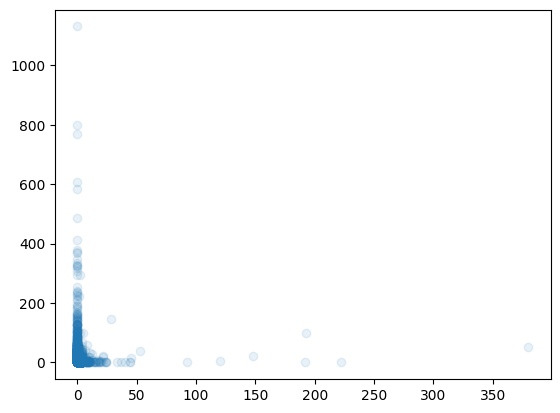

In [ ]:
plt.scatter(math_cnt, cit, alpha=0.1)

In [ ]:
df = pd.DataFrame({'math':math_cnt, 'cit':cit})

(-3.0, 200.0)

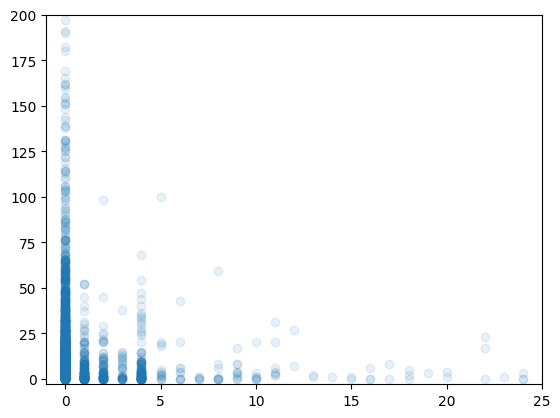

In [ ]:
plt.scatter(math_cnt, cit, alpha=0.1)
plt.xlim([-1, 25])
plt.ylim([-3, 200])

In [ ]:
dfpru = df[(df["math"] <= 25)]
dfpru.reset_index(drop=True, inplace=True)

<Axes: xlabel='math', ylabel='cit'>

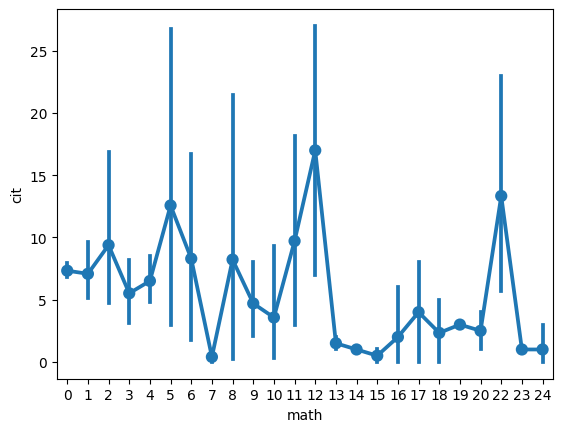

In [ ]:
import seaborn as sns
sns.pointplot(data=dfpru, x="math", y="cit")

These data analysis methods were used in the same way for my positive language analysis.